### **1.Install Required Libraries**

In [ ]:
!pip install pmdarima
!pip install pykalman
!pip install ruptures
!pip install statsmodels

### **2. Import Required Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
import ruptures as rpt
from scipy.fftpack import fft
from pykalman import KalmanFilter
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")


### **3. Data Preprocessing (Data Cleaning)**

**3.1 Load the Dataset**

In [ ]:
# Load the dataset
df = pd.read_csv("https://drive.google.com/uc?id=1DcEZemAvmlBxwmc4IEIkDRkTpHLAqTBH")

In [ ]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [ ]:
# Convert Timestamp to Datetime and set as index
df['Timestamp (GMT)'] = pd.to_datetime(df['Timestamp (GMT)'])
df.set_index('Timestamp (GMT)', inplace=True)

The 'Timestamp' column is treated as the actual dates and times, making it the main index in our data. This is important because time series analysis depends on understanding how things change over time, and this setup allows us to work with time easily

In [ ]:
df.head(300)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0
...,...,...,...,...
2015-08-17 18:50:00,159,51,NaN,NaN
2015-08-17 18:51:00,151,64,NaN,NaN
2015-08-17 18:52:00,140,64,NaN,NaN


**3.2. Check Correlation with Target Variable**

In [ ]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix['Lifetouch Heart Rate']
print(target_correlation)

Lifetouch Heart Rate          1.000000
Lifetouch Respiration Rate    1.000000
Oximeter SpO2                -0.001792
Oximeter Pulse                0.001593
Name: Lifetouch Heart Rate, dtype: float64


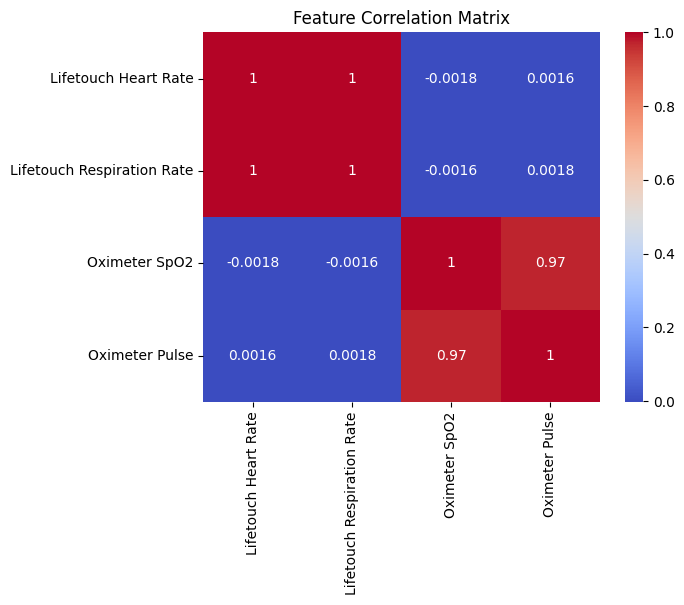

In [ ]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

The shows that respiration rate is strongly linked to heart rate, while SpO2 and pulse have little impact, guiding feature selection for more accurate heart rate predictions.

**3.4. Box Plot for Outlier Detection**

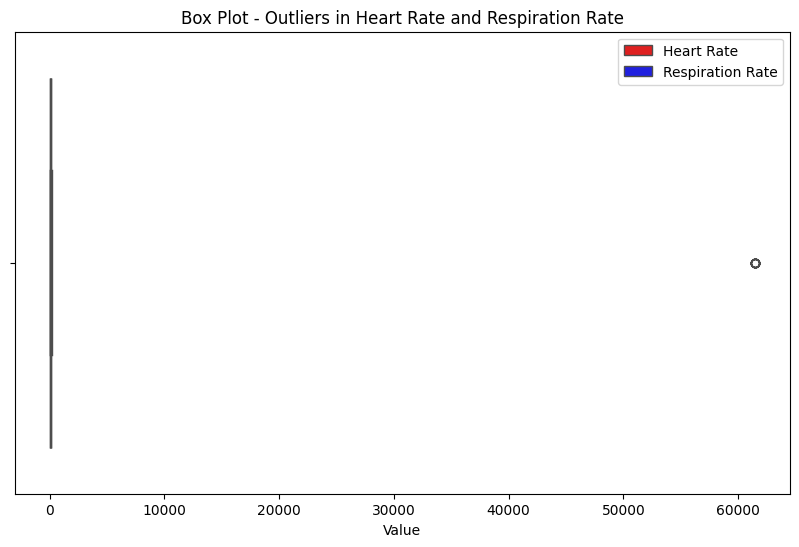

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Lifetouch Heart Rate'], color='red', label='Heart Rate')
sns.boxplot(x=df['Lifetouch Respiration Rate'], color='blue', label='Respiration Rate')
plt.title('Box Plot - Outliers in Heart Rate and Respiration Rate')
plt.xlabel('Value')
plt.legend()
plt.show()

Extreme values far from the rest suggests potential data entry errors or unusual physiological events, which requires further investigation.

**3.5. Check for Missing Values**

In [ ]:
df.isnull().sum()

,0
Lifetouch Heart Rate,0
Lifetouch Respiration Rate,0
Oximeter SpO2,35
Oximeter Pulse,35


There are missing values in some columns (e.g., Oximeter SpO2 and Oximeter Pulse) need to be addressed, as incomplete records can distort accurate time series analysis this values may not be needed since they are not correlated with the target.

**3.6. Handling Missing Values**

To maintain data continuity, we use forward fill (ffill) and backward fill (bfill) methods.

In [ ]:
# since the correlated fields are not having missing number no need of handling missing

This ensures gaps are filled logically without introducing bias.

**3.7. Statistical Summary**



In [ ]:
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


The presence of unusually high maximum values and negative minimum values suggests possible outliers.

Standardization or Outlier removal might be required later for feature scaling.

**3.8. Outlier Detection & Handling (IQR Method)**


In [ ]:
# Calculate IQR for 'Lifetouch Heart Rate'
Q1 = df['Lifetouch Heart Rate'].quantile(0.25)
Q3 = df['Lifetouch Heart Rate'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Lifetouch Heart Rate'] < lower_bound) | (df['Lifetouch Heart Rate'] > upper_bound)]
print(outliers)

# Replace outliers with the mode
df.loc[outliers.index, 'Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].mode()

# Handle potential NaN values after replacing outliers
df['Lifetouch Heart Rate'].fillna(df['Lifetouch Heart Rate'].mode()[0], inplace=True)

                     Lifetouch Heart Rate  Lifetouch Respiration Rate  \
Timestamp (GMT)                                                         
2015-08-17 15:39:00                 61441                       61441   
2015-08-17 15:40:00                 61442                       61442   
2015-08-17 15:41:00                 61441                       61441   
2015-08-17 15:42:00                 61441                       61441   
2015-08-17 15:43:00                 61441                       61441   
2015-08-17 15:44:00                 61441                       61441   
2015-08-17 15:45:00                 61442                       61442   
2015-08-17 15:50:00                 61442                       61442   

                     Oximeter SpO2  Oximeter Pulse  
Timestamp (GMT)                                     
2015-08-17 15:39:00           94.0           152.0  
2015-08-17 15:40:00           92.0           146.0  
2015-08-17 15:41:00           -1.0            -1.0  
2015

In [ ]:
# Calculate IQR for 'Lifetouch Respiration Rate'
Q1 = df['Lifetouch Respiration Rate'].quantile(0.25)
Q3 = df['Lifetouch Respiration Rate'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Lifetouch Respiration Rate'] < lower_bound) | (df['Lifetouch Respiration Rate'] > upper_bound)]
print(outliers)

# Replace outliers with the mode
df.loc[outliers.index, 'Lifetouch Respiration Rate'] = df['Lifetouch Respiration Rate'].mode()[0]

# Handle potential NaN values after replacing outliers (if any)
df['Lifetouch Respiration Rate'].fillna(df['Lifetouch Respiration Rate'].mode()[0], inplace=True)

                     Lifetouch Heart Rate  Lifetouch Respiration Rate  \
Timestamp (GMT)                                                         
2015-08-17 15:39:00                 136.0                       61441   
2015-08-17 15:40:00                 136.0                       61442   
2015-08-17 15:41:00                 136.0                       61441   
2015-08-17 15:42:00                 136.0                       61441   
2015-08-17 15:43:00                 136.0                       61441   
2015-08-17 15:44:00                 136.0                       61441   
2015-08-17 15:45:00                 136.0                       61442   
2015-08-17 15:50:00                 136.0                       61442   

                     Oximeter SpO2  Oximeter Pulse  
Timestamp (GMT)                                     
2015-08-17 15:39:00           94.0           152.0  
2015-08-17 15:40:00           92.0           146.0  
2015-08-17 15:41:00           -1.0            -1.0  
2015

 The IQR method was used to removes extreme fluctuations that could distort model accuracy.

### **4. Exploratory Data Analysis (EDA)**



**4.1. Time Series Plots**



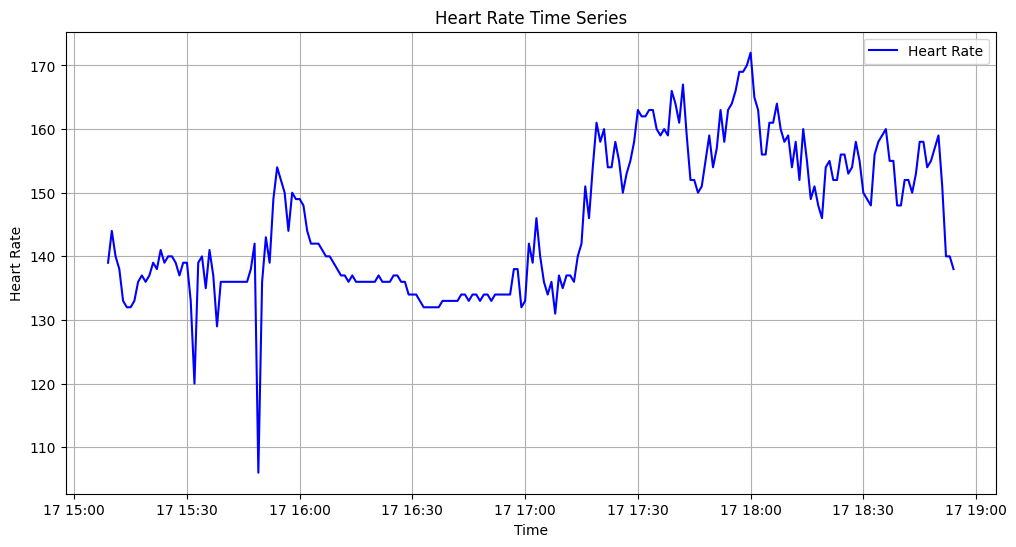

In [ ]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Lifetouch Heart Rate'], color='blue', label='Heart Rate')
plt.title('Heart Rate Time Series')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.grid(True)
plt.show()

The shows trends and anomalies. Sharp spikes hint at non-stationarity or sensor noise. Spotting these patterns aids forecasting and picking the right time series model.



**4.2. Distribution Analysis**


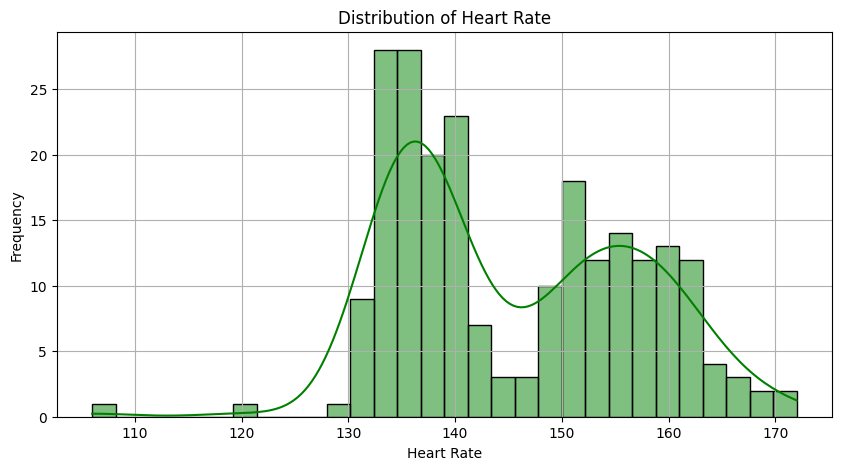

In [ ]:
# Distribution Analysis
plt.figure(figsize=(10, 5))
sns.histplot(df['Lifetouch Heart Rate'], kde=True, bins=30, color='green')
plt.title('Distribution of Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This reveals the distribution of heart rate, showing bimodal patterns and possible outliers. The kernel density estimate (KDE) highlights peaks, suggesting non-normality.

**4.3. Box Plot for Outlier Detection**



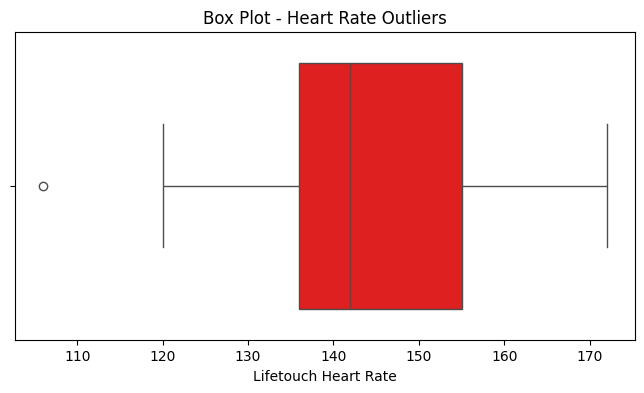

In [ ]:
# Box Plot for Outlier Detection
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Lifetouch Heart Rate'], color='red')
plt.title('Box Plot - Heart Rate Outliers')
plt.show()

The box plot shows heart rate distribution, with one outlier below the lower whisker. This suggests handling the anomaly detection which is necessary before forecasting to improve accuracy.

**4.5. Rolling Statistics**



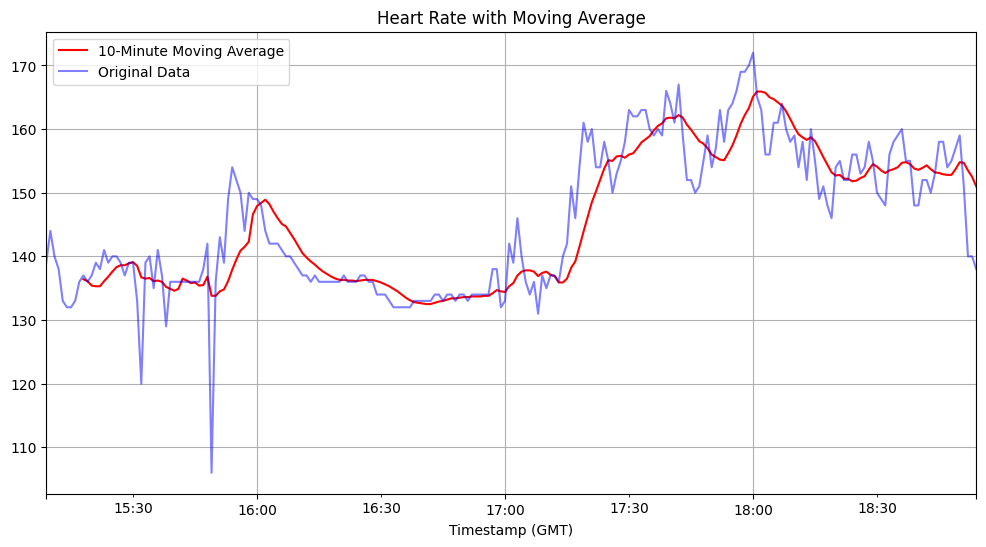

In [ ]:
# Rolling Statistics
plt.figure(figsize=(12, 6))
df['Lifetouch Heart Rate'].rolling(window=10).mean().plot(label='10-Minute Moving Average', color='red')
df['Lifetouch Heart Rate'].plot(label='Original Data', color='blue', alpha=0.5)
plt.title('Heart Rate with Moving Average')
plt.legend()
plt.grid(True)
plt.show()

The rolling average (red line) revealed underlying trends in the heart rate. The original data (blue line) shows more volatility, which can impact forecasting accuracy.

**4.6. Time Series Decomposition**


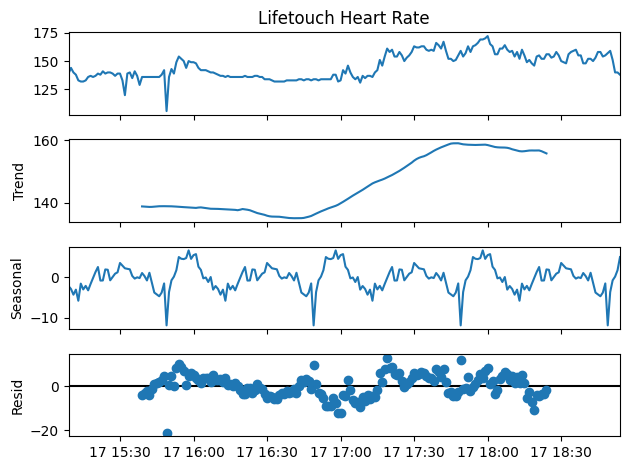

In [ ]:
# Time Series Decomposition
decomposition = seasonal_decompose(df['Lifetouch Heart Rate'], model='additive', period=60)
decomposition.plot()
plt.show()

The time series decomposition separates heart rate data into trend, seasonality, and residual noise. The trend shows long-term movement, while seasonality captures repeating cycles. The residuals highlight irregular fluctuations. For accurate forecasting, models like SARIMA which can handles trend and seasonality can be used in the dataset.

**4.7. Autocorrelation Analysis**



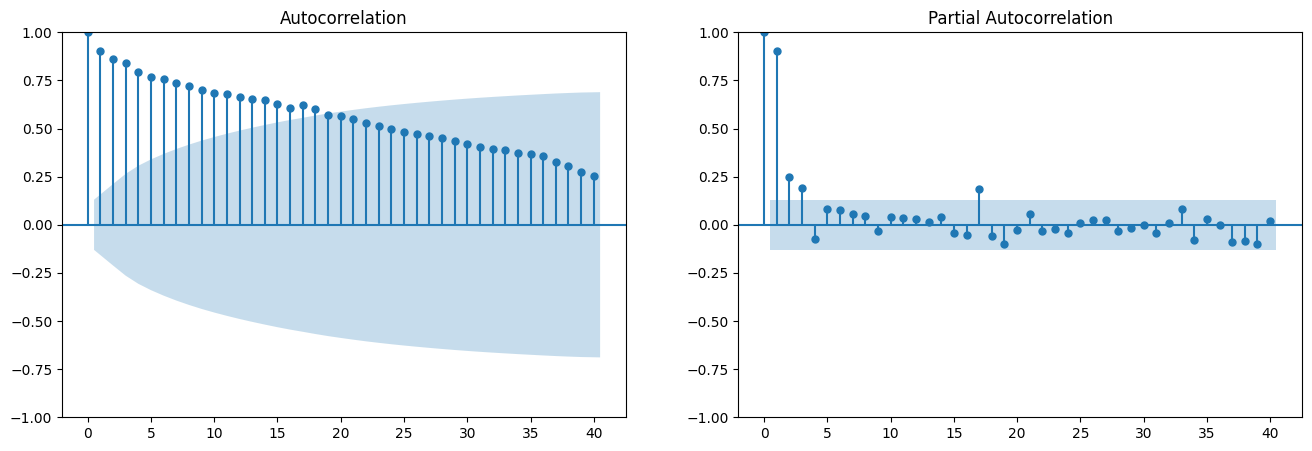

In [ ]:
# Autocorrelation Analysis
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['Lifetouch Heart Rate'], ax=ax[0], lags=40)
plot_pacf(df['Lifetouch Heart Rate'], ax=ax[1], lags=40)
plt.show()

These plots show how the past heart rate values influence future values, with a slow decay indicating long-term dependencies. The partial autocorrelation plot highlights the most important lags, with a strong first lag suggesting ARIMA can model short-term dependencies. Identifying these lags helps in parameter selection for forecasting models like ARIMA or SARIMA.

**4.8. Change Point Detection**



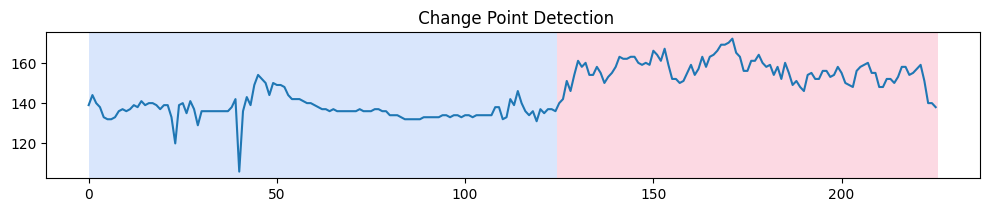

In [ ]:
# Change Point Detection
algo = rpt.Pelt(model="rbf").fit(df['Lifetouch Heart Rate'].values)
result = algo.predict(pen=10)
rpt.display(df['Lifetouch Heart Rate'].values, result)
plt.title(' Change Point Detection')
plt.show()

This shows sudden shifts in heart rate trends, marking structural breaks in the time series. These shifts, highlighted in different colors, suggest possible trend changes due to physiological variations or external factors. Identifying these points helps refine forecasting models like ARIMA.

**4.9. Fourier Transform Analysis**

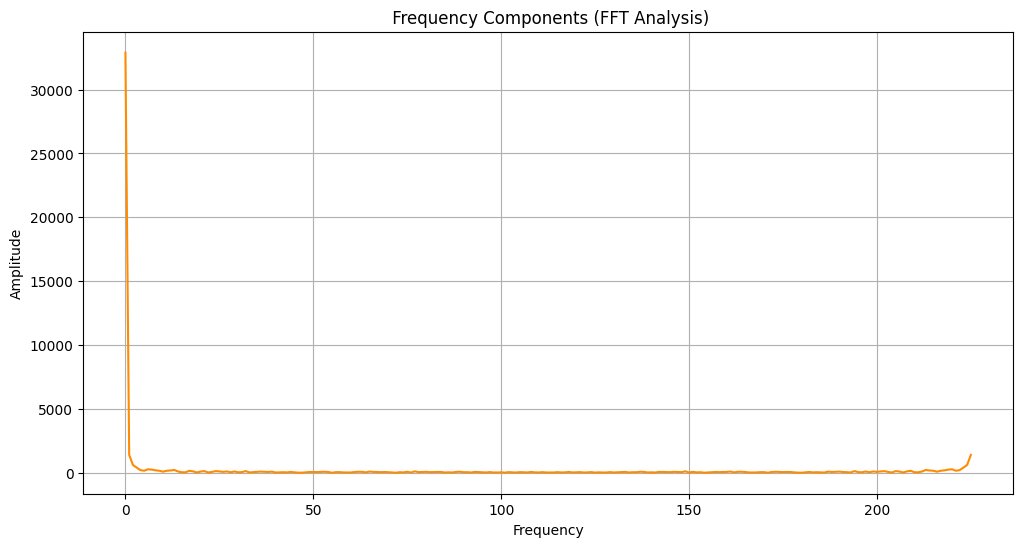

In [ ]:
# Fourier Transform Analysis
fft_values = fft(df['Lifetouch Heart Rate'].values)
frequencies = np.abs(fft_values)
plt.figure(figsize=(12, 6))
plt.plot(frequencies, color='darkorange')
plt.title(' Frequency Components (FFT Analysis)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

The Fourier Transform (FFT) identifies dominant frequency components in heart rate data. The sharp peak at the start suggests a strong low-frequency trend, indicating underlying patterns or seasonality. This helps in detecting cyclic behaviors and refining forecasting models like SARIMA for better predictions.

### **5. Stationarity Testing**


In [ ]:
# check stationarity of the series
def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')

In [ ]:
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



The stationarity test checks if the heart rate data has a constant mean and variance over time. The p-value (0.01) is below 0.05, indicating non-stationarity. To enhance forecasting accuracy, differencing or other transformation techniques such as log transformation or power transformation may be required to stabilize the data before applying models that assume stationary time series.

### **6. Feature Engineering & Data Transformation**

**6.1. Log Transformation**



In [ ]:
## Log Transformation
df['Log-Heart-Rate'] = np.log(df['Lifetouch Heart Rate'] + 1)  # +1 to avoid log(0)
print(df.shape)
df.head()

(226, 5)


,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Log-Heart-Rate
Timestamp (GMT),,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,4.941642
2015-08-17 15:10:00,144.0,40,92.0,140.0,4.976734
2015-08-17 15:11:00,140.0,42,89.0,144.0,4.948760
2015-08-17 15:12:00,138.0,45,93.0,141.0,4.934474
2015-08-17 15:13:00,133.0,42,94.0,134.0,4.897840


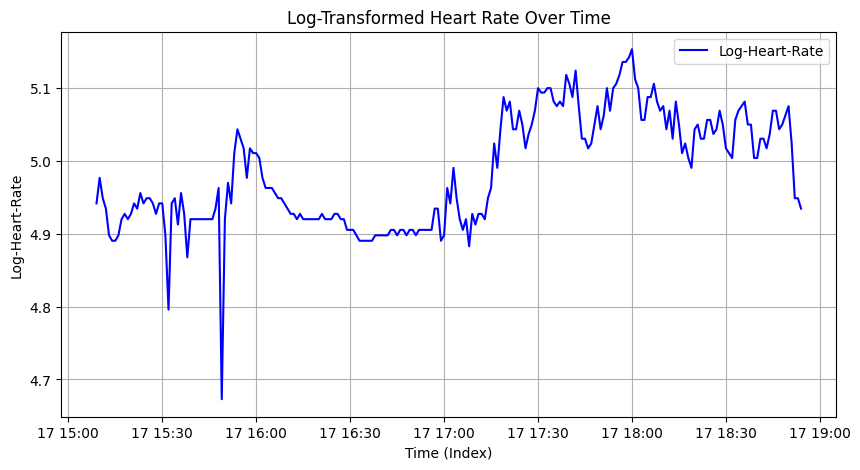

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Log-Heart-Rate'], color='blue', label='Log-Heart-Rate')
plt.title('Log-Transformed Heart Rate Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Log-Heart-Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
check_stationarity(df['Log-Heart-Rate'])

p value: 0.01
Result: The series is not stationary 



Apply log transformation to reduce variance thereby make the time series more suitable for modeling. However, in this dataset after multiple logs transformations, the stationarity test confirms non-stationarity. This suggests the need for further processing, such as differencing, to stabilize the time series for better forecasting.


**6.2 Deseasonalisation (Seasonal Differencing)**




In [ ]:
# Apply seasonal differencing
df['Deseasonalised-Heart-Rate'] = df['Lifetouch Heart Rate'].diff(periods=1)
# Fill NaN values with the next valid value (backward fill)
df['Deseasonalised-Heart-Rate'].fillna(method='bfill', inplace=True)  # Backward fill
df.head(15)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Log-Heart-Rate,Deseasonalised-Heart-Rate
Timestamp (GMT),,,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,4.941642,5.0
2015-08-17 15:10:00,144.0,40,92.0,140.0,4.976734,5.0
2015-08-17 15:11:00,140.0,42,89.0,144.0,4.948760,-4.0
2015-08-17 15:12:00,138.0,45,93.0,141.0,4.934474,-2.0
2015-08-17 15:13:00,133.0,42,94.0,134.0,4.897840,-5.0
2015-08-17 15:14:00,132.0,41,92.0,134.0,4.890349,-1.0
2015-08-17 15:15:00,132.0,47,92.0,135.0,4.890349,0.0
2015-08-17 15:16:00,133.0,44,92.0,135.0,4.897840,1.0
2015-08-17 15:17:00,136.0,45,94.0,136.0,4.919981,3.0


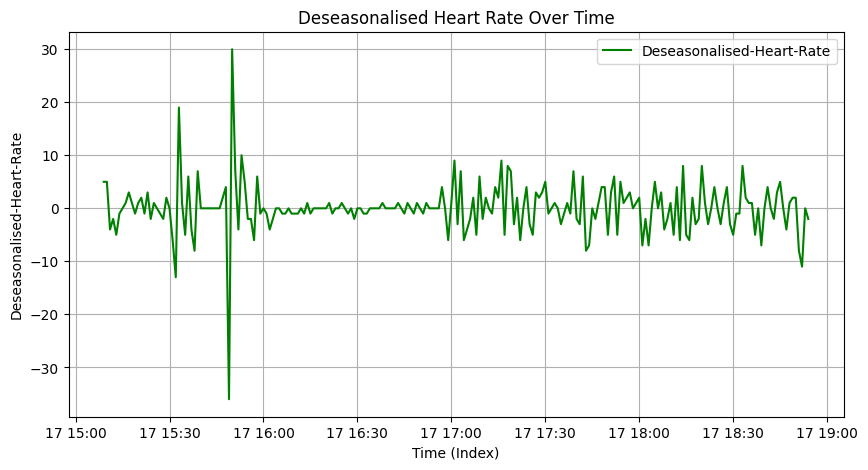

In [ ]:
# Plot Deseasonalised Heart Rate
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Deseasonalised-Heart-Rate'], color='green', label='Deseasonalised-Heart-Rate')
plt.title('Deseasonalised Heart Rate Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Deseasonalised-Heart-Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
check_stationarity(df['Deseasonalised-Heart-Rate'][1:])

p value: 0.1
Result: The series is stationary 



Seasonal differencing eliminates recurring patterns, stabilizing the series for time series models. This is useful for data with seasonal trends, such as daily temperature changes or monthly sales variations.

After Seasonal differencing, the stationarity test confirms that the series is now stationary, making it suitable for time series modeling.

**6.3. Differencing (Trend Differencing)**



In [ ]:
# Apply first-order differencing
df['Differenced-Heart-Rate'] = df['Lifetouch Heart Rate'].diff(periods=1)
# Fill missing values
df['Differenced-Heart-Rate'].fillna(method='bfill', inplace=True)
df.head(15)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Log-Heart-Rate,Deseasonalised-Heart-Rate,Differenced-Heart-Rate
Timestamp (GMT),,,,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,4.941642,5.0,5.0
2015-08-17 15:10:00,144.0,40,92.0,140.0,4.976734,5.0,5.0
2015-08-17 15:11:00,140.0,42,89.0,144.0,4.948760,-4.0,-4.0
2015-08-17 15:12:00,138.0,45,93.0,141.0,4.934474,-2.0,-2.0
2015-08-17 15:13:00,133.0,42,94.0,134.0,4.897840,-5.0,-5.0
2015-08-17 15:14:00,132.0,41,92.0,134.0,4.890349,-1.0,-1.0
2015-08-17 15:15:00,132.0,47,92.0,135.0,4.890349,0.0,0.0
2015-08-17 15:16:00,133.0,44,92.0,135.0,4.897840,1.0,1.0
2015-08-17 15:17:00,136.0,45,94.0,136.0,4.919981,3.0,3.0


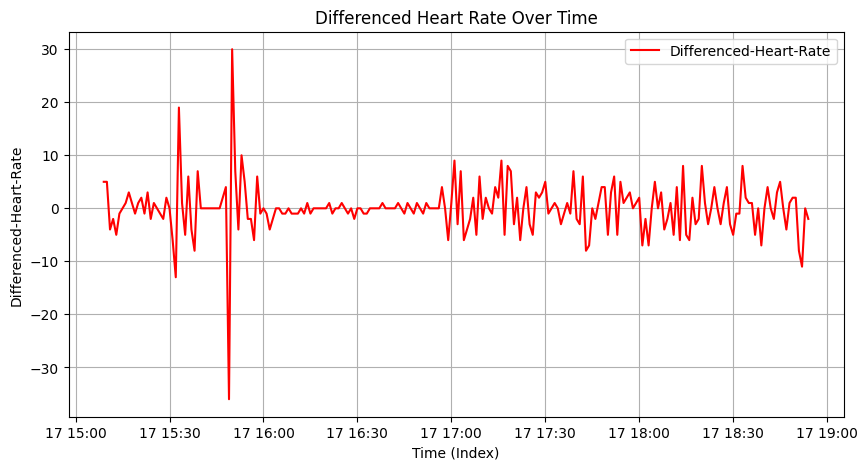

In [ ]:
# Plot Differenced Heart Rate
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Differenced-Heart-Rate'], color='red', label='Differenced-Heart-Rate')
plt.title('Differenced Heart Rate Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Differenced-Heart-Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
check_stationarity(df['Differenced-Heart-Rate'][2:])

p value: 0.1
Result: The series is stationary 



After applying first-order differencing, the stationarity test confirms that the series is now stationary, suitable for foresasting model such as ARIMA modeling.

In [ ]:
df.head(300)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Log-Heart-Rate,Deseasonalised-Heart-Rate,Differenced-Heart-Rate
Timestamp (GMT),,,,,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN,4.941642,5.0,5.0
2015-08-17 15:10:00,144.0,40,92.0,140.0,4.976734,5.0,5.0
2015-08-17 15:11:00,140.0,42,89.0,144.0,4.948760,-4.0,-4.0
2015-08-17 15:12:00,138.0,45,93.0,141.0,4.934474,-2.0,-2.0
2015-08-17 15:13:00,133.0,42,94.0,134.0,4.897840,-5.0,-5.0
...,...,...,...,...,...,...,...
2015-08-17 18:50:00,159.0,51,NaN,NaN,5.075174,2.0,2.0
2015-08-17 18:51:00,151.0,64,NaN,NaN,5.023881,-8.0,-8.0
2015-08-17 18:52:00,140.0,64,NaN,NaN,4.948760,-11.0,-11.0


### **7. Model Training & Forecasting**

**7.1 ARIMA MODEL**

In [ ]:
# specify the model
arima_model = ARIMA(df['Lifetouch Heart Rate'],
                    order=(1, 1, 2))

# train the arima model
arima_results = arima_model.fit()
# Print model summary
print(arima_results.summary())

                                SARIMAX Results                                 
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                   ARIMA(1, 1, 2)   Log Likelihood                -662.992
Date:                  Fri, 28 Feb 2025   AIC                           1333.984
Time:                          06:55:58   BIC                           1347.649
Sample:                      08-17-2015   HQIC                          1339.500
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5554      0.233     -2.387      0.017      -1.012      -0.099
ma.L1          0.2291      0.236      0.970      0.332      -0.234       0.692
ma.L2         -0.3216      0.077    

In [ ]:
# predict
arima_predict= arima_results.predict(start=pd.to_datetime('2015-08-17 16:49:00'), end=pd.to_datetime('2015-08-17 17:15:00'), dynamic = False)
print(arima_predict.head(20))


2015-08-17 16:49:00    133.326450
2015-08-17 16:50:00    133.855445
2015-08-17 16:51:00    133.816504
2015-08-17 16:52:00    133.321895
2015-08-17 16:53:00    133.862497
2015-08-17 16:54:00    133.813423
2015-08-17 16:55:00    133.998523
2015-08-17 16:56:00    133.940336
2015-08-17 16:57:00    134.013194
2015-08-17 16:58:00    136.672408
2015-08-17 16:59:00    137.021993
2015-08-17 17:00:00    133.755176
2015-08-17 17:01:00    133.886619
2015-08-17 17:02:00    139.102637
2015-08-17 17:03:00    138.033554
2015-08-17 17:04:00    143.969999
2015-08-17 17:05:00    139.861136
2015-08-17 17:06:00    138.613941
2015-08-17 17:07:00    135.295586
2015-08-17 17:08:00    136.534335
Freq: min, Name: predicted_mean, dtype: float64


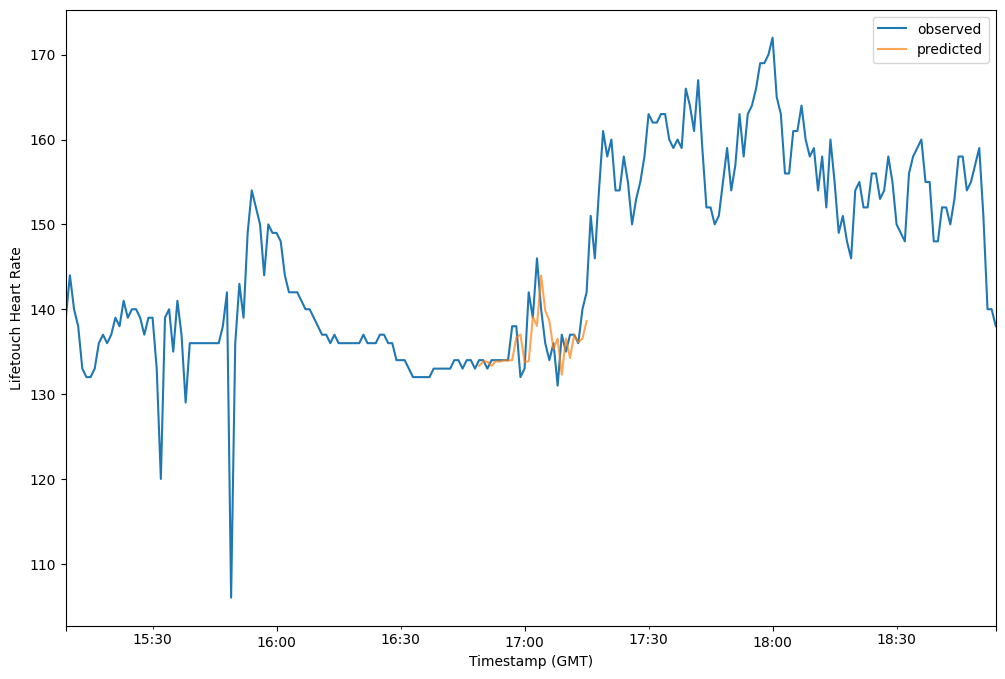

In [ ]:
# plot observations and predictions
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
arima_predict.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# calculate MSE MAE RMSE
actuals = df['2015-08-17 16:49:00':'2015-08-17 17:15:00']['Lifetouch Heart Rate']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, arima_predict ), 2)}')
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, arima_predict ), 2)}')
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, arima_predict )), 2)}')

Mean Squared Error: 11.6
Mean Absolute Error: 2.39
Root Mean Squared Error: 3.41


In [ ]:
# Out-of-sample forecasts
arima_forecasts = arima_results.forecast(steps=20)
# Add ARIMA forecast to test DataFrame
#df['ARIMA_Forecast'] = arima_forecasts
print(arima_forecasts)

2015-08-17 18:55:00    139.717383
2015-08-17 18:56:00    140.347924
2015-08-17 18:57:00    139.997696
2015-08-17 18:58:00    140.192227
2015-08-17 18:59:00    140.084177
2015-08-17 19:00:00    140.144192
2015-08-17 19:01:00    140.110857
2015-08-17 19:02:00    140.129373
2015-08-17 19:03:00    140.119088
2015-08-17 19:04:00    140.124801
2015-08-17 19:05:00    140.121628
2015-08-17 19:06:00    140.123390
2015-08-17 19:07:00    140.122411
2015-08-17 19:08:00    140.122955
2015-08-17 19:09:00    140.122653
2015-08-17 19:10:00    140.122821
2015-08-17 19:11:00    140.122728
2015-08-17 19:12:00    140.122779
2015-08-17 19:13:00    140.122751
2015-08-17 19:14:00    140.122767
Freq: min, Name: predicted_mean, dtype: float64


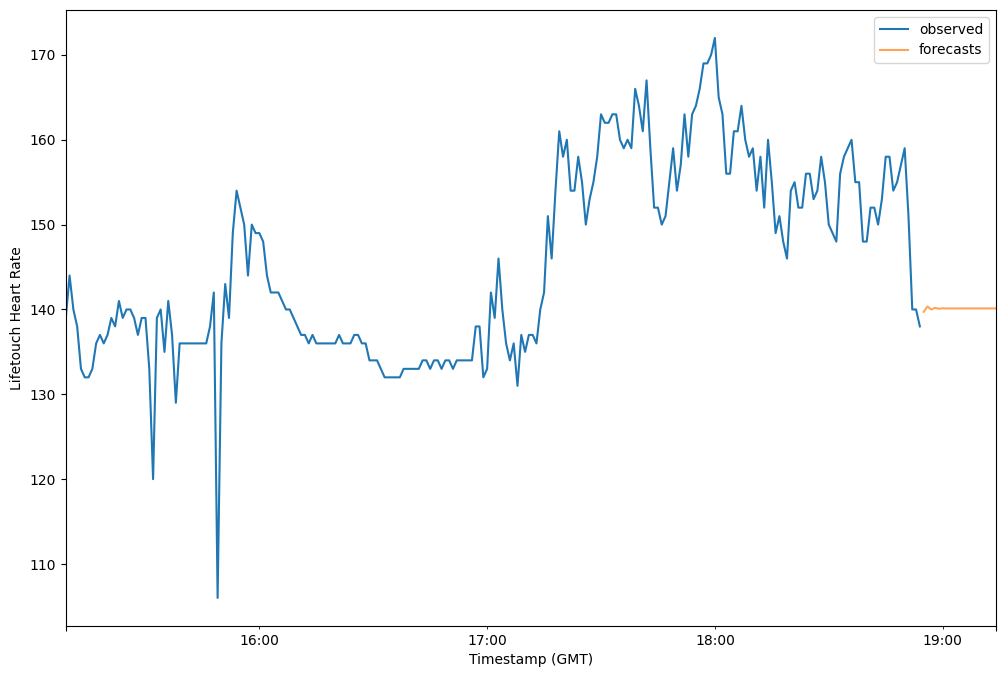

In [ ]:
# plot observations and forecasts
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
arima_forecasts.plot(ax=ax, label='forecasts', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

**7.2. SARIMA MODEL**

In [ ]:
# specify model
sarima_model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                order=(1, 1, 2),
                                seasonal_order=(1, 1, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# train the sarima model
sarima_results = sarima_model.fit()
# Print model summary
print(sarima_results.summary())


                                      SARIMAX Results                                       
Dep. Variable:                 Lifetouch Heart Rate   No. Observations:                  226
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 24)   Log Likelihood                -518.767
Date:                              Fri, 28 Feb 2025   AIC                           1049.534
Time:                                      06:56:47   BIC                           1068.488
Sample:                                  08-17-2015   HQIC                          1057.223
                                       - 08-17-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6286      0.276     -2.275      0.023      -1.170      -0.087
ma.L1          0.46

In [ ]:
# predict
sarima_predict= sarima_results.predict(start=pd.to_datetime('2015-08-17 16:49:00'), end=pd.to_datetime('2015-08-17 17:15:00'), dynamic = False)
print(sarima_predict.head(20))


2015-08-17 16:49:00    133.118969
2015-08-17 16:50:00    133.048317
2015-08-17 16:51:00    131.523702
2015-08-17 16:52:00    132.881674
2015-08-17 16:53:00    132.338384
2015-08-17 16:54:00    133.324647
2015-08-17 16:55:00    133.212015
2015-08-17 16:56:00    133.317541
2015-08-17 16:57:00    132.713849
2015-08-17 16:58:00    136.690503
2015-08-17 16:59:00    136.549631
2015-08-17 17:00:00    132.732224
2015-08-17 17:01:00    135.297685
2015-08-17 17:02:00    139.710150
2015-08-17 17:03:00    137.520664
2015-08-17 17:04:00    145.387552
2015-08-17 17:05:00    138.785227
2015-08-17 17:06:00    137.775840
2015-08-17 17:07:00    134.643926
2015-08-17 17:08:00    136.693476
Freq: min, Name: predicted_mean, dtype: float64


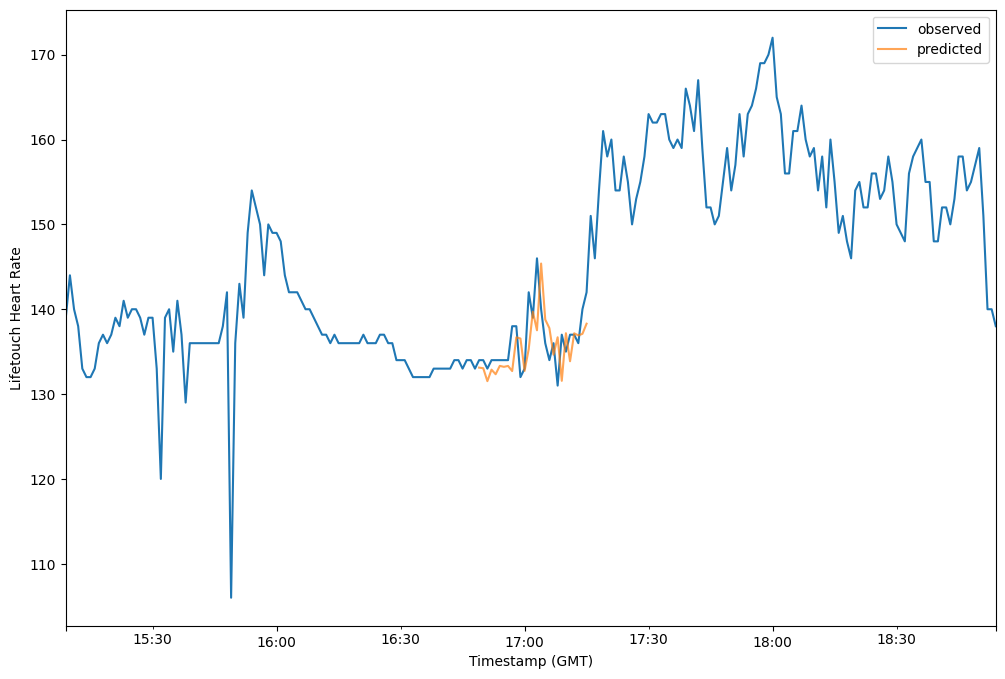

In [ ]:
# plot observations and predictions
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
sarima_predict.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# calculate MSE MAE RMSE
actuals = df['2015-08-17 16:49:00':'2015-08-17 17:15:00']['Lifetouch Heart Rate']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, sarima_predict ), 2)}')
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, sarima_predict ), 2)}')
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, sarima_predict )), 2)}')

Mean Squared Error: 12.21
Mean Absolute Error: 2.7
Root Mean Squared Error: 3.49


In [ ]:
# Out-of-sample forecasts
sarima_forecasts = sarima_results.forecast(steps=20)
# Add SARIMA forecast to test DataFrame
#df['SARIMA_Forecast'] = sarima_forecasts
print(sarima_forecasts)

2015-08-17 18:55:00    138.866713
2015-08-17 18:56:00    137.291454
2015-08-17 18:57:00    141.171705
2015-08-17 18:58:00    143.064564
2015-08-17 18:59:00    141.374515
2015-08-17 19:00:00    143.572862
2015-08-17 19:01:00    137.550272
2015-08-17 19:02:00    141.304229
2015-08-17 19:03:00    134.611326
2015-08-17 19:04:00    131.678884
2015-08-17 19:05:00    135.361892
2015-08-17 19:06:00    133.805416
2015-08-17 19:07:00    131.622795
2015-08-17 19:08:00    136.833366
2015-08-17 19:09:00    140.186806
2015-08-17 19:10:00    138.891455
2015-08-17 19:11:00    136.316806
2015-08-17 19:12:00    138.537523
2015-08-17 19:13:00    140.220313
2015-08-17 19:14:00    140.273134
Freq: min, Name: predicted_mean, dtype: float64


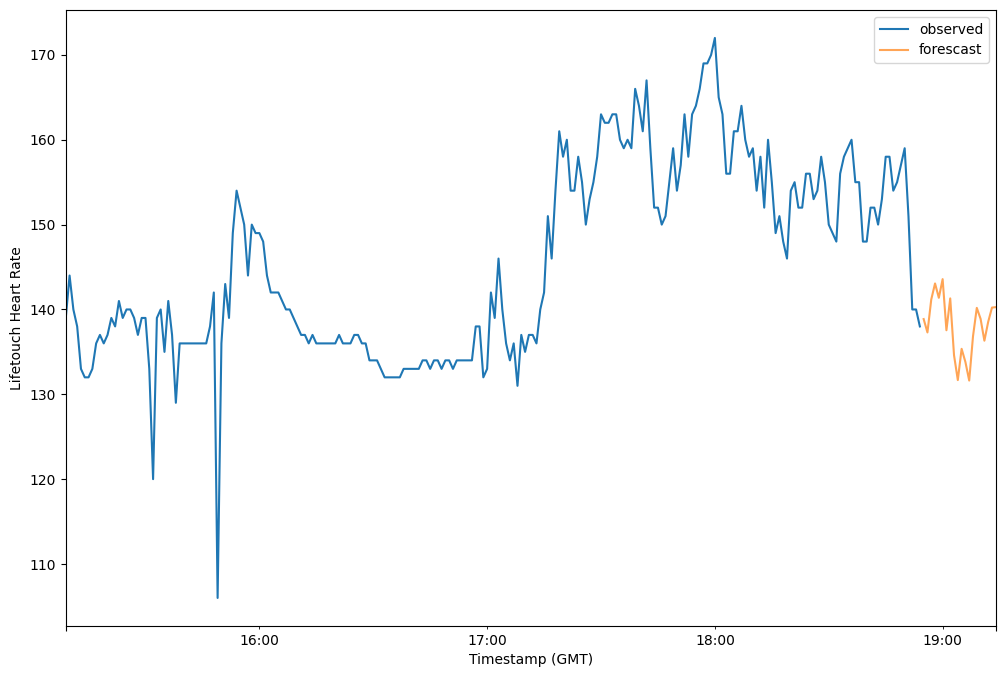

In [ ]:
# plot observations and predictions
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
sarima_forecasts.plot(ax=ax, label='forescast', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

**3.3. SARIMAX**

In [ ]:
# specify model
sarimax_model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(1, 1, 2),
                                  seasonal_order=(1, 1, 1, 24),
                                  exog=df[['Lifetouch Respiration Rate']],  # Exogenous variable
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train the sarima model
sarimax_results = sarimax_model.fit()
# Print model summary
print(sarimax_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                 Lifetouch Heart Rate   No. Observations:                  226
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 24)   Log Likelihood                -518.535
Date:                              Fri, 28 Feb 2025   AIC                           1051.071
Time:                                      06:57:32   BIC                           1073.184
Sample:                                  08-17-2015   HQIC                          1060.042
                                       - 08-17-2015                                         
Covariance Type:                                opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Lifetouch Respiration Rate    -0.0565      0.077     -0.729      0

In [ ]:
# predict
sarimax_predict= sarimax_results.predict(start=pd.to_datetime('2015-08-17 16:49:00'), end=pd.to_datetime('2015-08-17 17:15:00'), dynamic = False)
print(sarima_predict.head(20))


2015-08-17 16:49:00    133.118969
2015-08-17 16:50:00    133.048317
2015-08-17 16:51:00    131.523702
2015-08-17 16:52:00    132.881674
2015-08-17 16:53:00    132.338384
2015-08-17 16:54:00    133.324647
2015-08-17 16:55:00    133.212015
2015-08-17 16:56:00    133.317541
2015-08-17 16:57:00    132.713849
2015-08-17 16:58:00    136.690503
2015-08-17 16:59:00    136.549631
2015-08-17 17:00:00    132.732224
2015-08-17 17:01:00    135.297685
2015-08-17 17:02:00    139.710150
2015-08-17 17:03:00    137.520664
2015-08-17 17:04:00    145.387552
2015-08-17 17:05:00    138.785227
2015-08-17 17:06:00    137.775840
2015-08-17 17:07:00    134.643926
2015-08-17 17:08:00    136.693476
Freq: min, Name: predicted_mean, dtype: float64


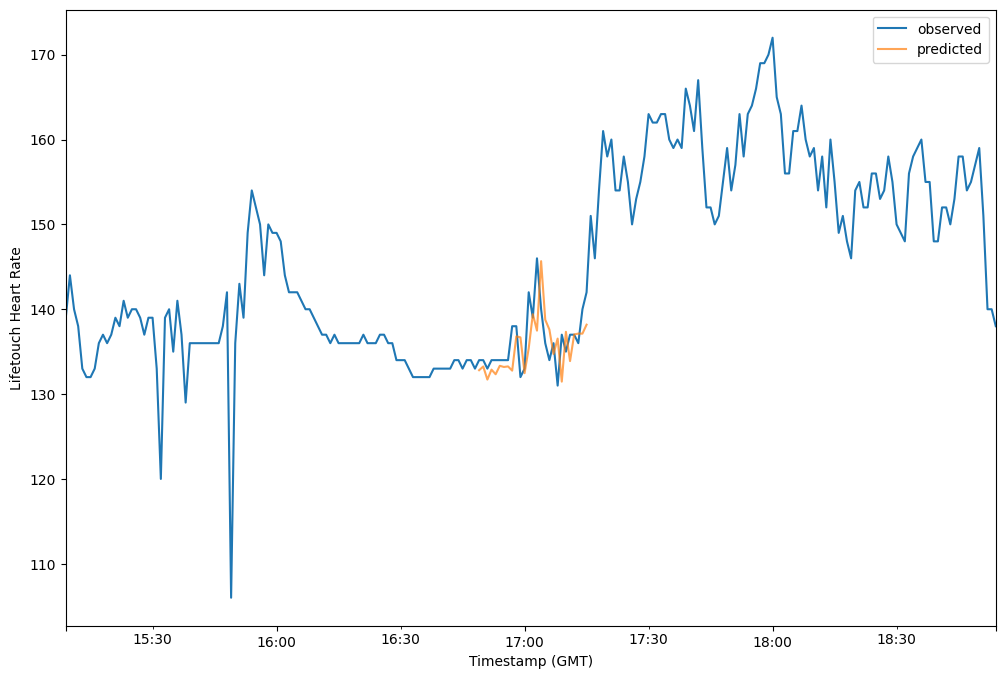

In [ ]:
# plot observations and predictions
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
sarimax_predict.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

In [ ]:
# calculate MSE MAE RMSE
actuals = df['2015-08-17 16:49:00':'2015-08-17 17:15:00']['Lifetouch Heart Rate']
print(f'Mean Squared Error: {round(mean_squared_error(actuals, sarimax_predict ), 2)}')
print(f'Mean Absolute Error: {round(mean_absolute_error(actuals, sarimax_predict ), 2)}')
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, sarimax_predict )), 2)}')

Mean Squared Error: 12.28
Mean Absolute Error: 2.71
Root Mean Squared Error: 3.5


In [ ]:
# For SARIMAX:
future_exog = df[['Lifetouch Respiration Rate']][-20:]
sarimax_forecasts = sarimax_results.get_forecast(steps=20, exog=future_exog).predicted_mean
# Add SARIMA forecast to test DataFrame
df['SARIMAX_Forecast'] = sarimax_forecasts
print(sarimax_forecasts)

2015-08-17 18:55:00    139.322697
2015-08-17 18:56:00    137.143053
2015-08-17 18:57:00    141.425044
2015-08-17 18:58:00    143.617474
2015-08-17 18:59:00    141.418126
2015-08-17 19:00:00    144.102457
2015-08-17 19:01:00    137.926697
2015-08-17 19:02:00    141.270921
2015-08-17 19:03:00    134.675409
2015-08-17 19:04:00    132.021339
2015-08-17 19:05:00    135.773872
2015-08-17 19:06:00    134.459434
2015-08-17 19:07:00    132.227956
2015-08-17 19:08:00    136.772267
2015-08-17 19:09:00    140.492197
2015-08-17 19:10:00    139.344917
2015-08-17 19:11:00    135.793774
2015-08-17 19:12:00    138.144046
2015-08-17 19:13:00    140.268966
2015-08-17 19:14:00    140.560401
Freq: min, Name: predicted_mean, dtype: float64


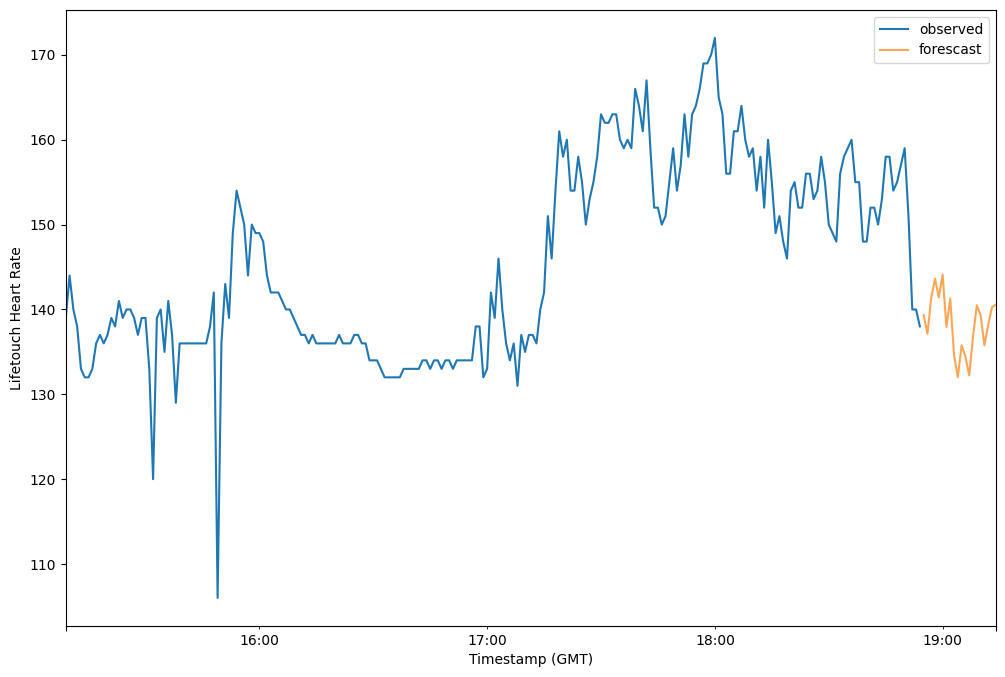

In [ ]:
# plot observations and predictions
ax = df['Lifetouch Heart Rate'].plot(label='observed', figsize=(12, 8))
sarimax_forecasts.plot(ax=ax, label='forescast', alpha=.7)

ax.set_xlabel('Timestamp (GMT)')
ax.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

#### **Heart Rate Comparison Curves**

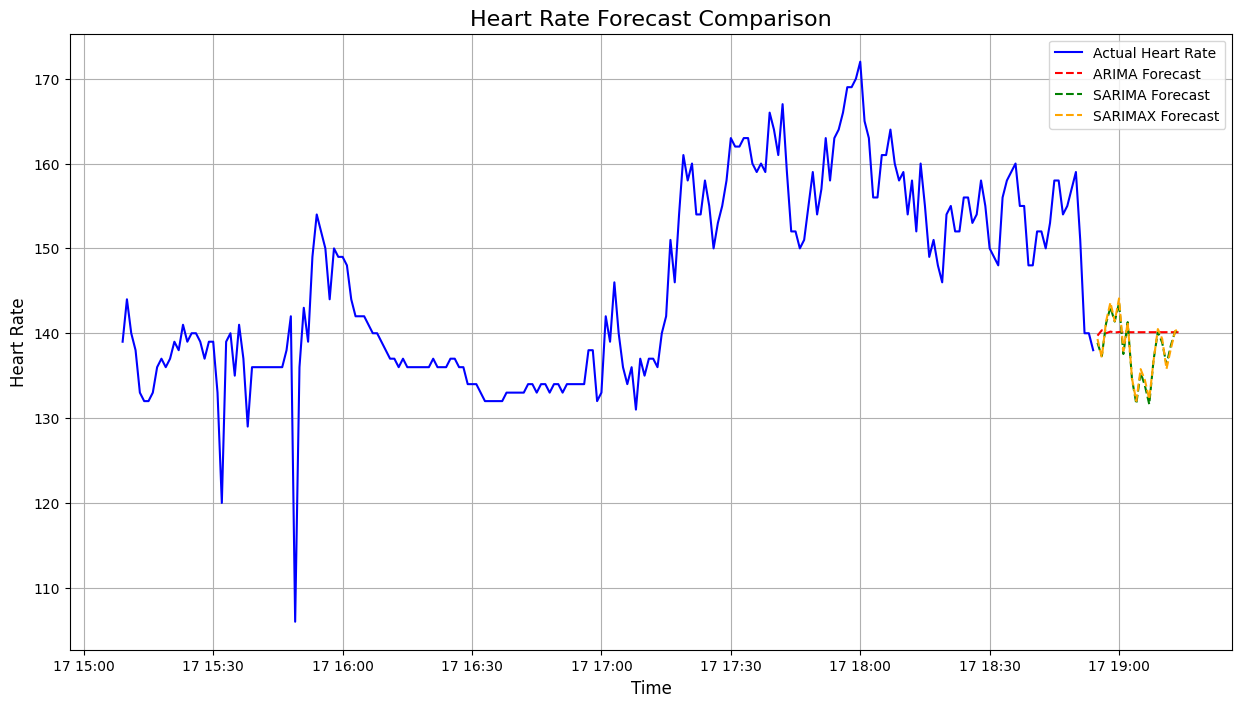

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(15, 8))

plt.plot(df.index, df['Lifetouch Heart Rate'], label='Actual Heart Rate', color='blue')
plt.plot(arima_forecasts.index, arima_forecasts.values, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(sarima_forecasts.index, sarima_forecasts.values, label='SARIMA Forecast', color='green', linestyle='--')
plt.plot(sarimax_forecasts.index, sarimax_forecasts.values, label='SARIMAX Forecast', color='orange', linestyle='--')
plt.title('Heart Rate Forecast Comparison', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Heart Rate', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)

plt.show()

### **12. Save Final Predictions**



In [ ]:
#arima_forecast_df = pd.DataFrame({'Predictions': arima_forecasts}, index=arima_forecasts.index)
sarima_forecast_df = pd.DataFrame({'Predictions': sarima_forecasts}, index=sarima_forecasts.index)
#sarimax_forecast_df = pd.DataFrame({'Predictions': sarimax_forecasts}, index=sarimax_forecasts.index)

sarima_forecast_df.head(100)

,Predictions
2015-08-17 18:55:00,138.866713
2015-08-17 18:56:00,137.291454
2015-08-17 18:57:00,141.171705
2015-08-17 18:58:00,143.064564
2015-08-17 18:59:00,141.374515
2015-08-17 19:00:00,143.572862
2015-08-17 19:01:00,137.550272
2015-08-17 19:02:00,141.304229
2015-08-17 19:03:00,134.611326
2015-08-17 19:04:00,131.678884


In [ ]:
sarima_forecast_df.index = range(1, len(sarima_forecast_df) + 1)

sarima_forecast_df.index.name = 'Index'

sarima_forecast_df.to_csv('sarima_forecast_index_prediction.csv')

print("DataFrame saved to 'sarima_forecast_index_prediction.csv'")

DataFrame saved to 'sarima_forecast_index_prediction.csv'
